In [1]:
# Purpose:  Derived features based on known candidate supporters' daily counts of pos & neg tweets towerds candidates.
#           Apply unsupervised K-means clustering. Look at elbow graph. Look at results for various K:  graph
#           centroids, show user composition of each cluster, show cluster memebership by type of user.
#           Apply 'supervised K-means clustering':  Calculate centroid of each user group.  Graph centroids.
#           Assign each user to the nearest cluster. Calculate performance metrics.
#           Test various minimum tweet thresholds for applying labels. Graph classifier performance & loss of support
#           by threshold.
# Author:  Carol Sniegoski, adapted from Preeti Javaji
# Date:  June 2016
# Course:  MAS DSE capstone, Spring 2016

In [2]:
%cd /Users/preetijavaji/Documents/DSE/capstone/user_analysis/kmeans

/Users/preetijavaji/Documents/DSE/capstone/user_analysis/kmeans


In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

pd.set_option('display.max_colwidth', 240)
pd.set_option('display.max_columns', 50)

print 'done'

done


In [185]:
#summary_df = pd.read_csv('../data/candidateSentiment/20151013.csv')
summary_df = pd.read_csv('../data/candidateSentiment/2016211.csv')

summary_df.head()

,Unnamed: 0,user,Trump_neg,Trump_neu,Trump_pos,Clinton_neg,Clinton_neu,Clinton_pos,Sanders_neg,Sanders_neu,Sanders_pos,Rubio_neg,Rubio_neu,Rubio_pos,Cruz_neg,Cruz_neu,Cruz_pos,supports,frequency
0,9414610,000000000001110,2,4,0,1,1,0,0,1,1,0,0,0,0,0,0,none,11
1,9414611,000000x6,0,0,0,0,2,0,1,2,2,0,0,0,0,0,0,none,8
2,9414612,00001kat,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,none,2
3,9414613,0000sensei,0,0,0,0,1,3,1,2,0,0,0,0,0,0,0,none,7
4,9414614,000120o,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,none,2


In [186]:
# First confirm if we have supporters for all 5 candidates
print summary_df['supports'].unique()
print summary_df['supports'].value_counts()

['none' 'Trump' 'Clinton' 'Cruz' 'Sanders' 'Rubio' 'Paul' 'Fiorina']
none       491724
Sanders      3967
Trump        3528
Clinton      1529
Cruz         1247
Rubio         499
Fiorina         1
Paul            1
dtype: int64


In [187]:
candidates = ['Trump','Sanders','Clinton','Cruz','Rubio']
features = list(summary_df.columns)
features.remove('Unnamed: 0')
features.remove('user')
features.remove('supports')
features.remove('frequency')
print features

['Trump_neg', 'Trump_neu', 'Trump_pos', 'Clinton_neg', 'Clinton_neu', 'Clinton_pos', 'Sanders_neg', 'Sanders_neu', 'Sanders_pos', 'Rubio_neg', 'Rubio_neu', 'Rubio_pos', 'Cruz_neg', 'Cruz_neu', 'Cruz_pos']


In [184]:
# Ratio features
candidates = ['Trump', 'Clinton', 'Sanders', 'Cruz', 'Rubio']
features = []
for candidate in candidates:
    summary_df[candidate+'_ratio'] = (summary_df[candidate+'_pos']+1)/(summary_df[candidate+'_neg']+1)
    features.append( candidate+'_ratio')
print features
summary_df.head()

['Trump_ratio', 'Clinton_ratio', 'Sanders_ratio', 'Cruz_ratio', 'Rubio_ratio']


,Unnamed: 0,user,Trump_neg,Trump_neu,Trump_pos,Clinton_neg,Clinton_neu,Clinton_pos,Sanders_neg,Sanders_neu,Sanders_pos,Rubio_neg,Rubio_neu,Rubio_pos,Cruz_neg,Cruz_neu,Cruz_pos,supports,frequency,Trump_ratio,Clinton_ratio,Sanders_ratio,Cruz_ratio,Rubio_ratio
0,9414610,000000000001110,2,4,0,1,1,0,0,1,1,0,0,0,0,0,0,none,11,0.333333,0.5,2.0,1,1
1,9414611,000000x6,0,0,0,0,2,0,1,2,2,0,0,0,0,0,0,none,8,1.000000,1.0,1.5,1,1
2,9414612,00001kat,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,none,2,1.000000,0.5,1.0,1,1
3,9414613,0000sensei,0,0,0,0,1,3,1,2,0,0,0,0,0,0,0,none,7,1.000000,4.0,0.5,1,1
4,9414614,000120o,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,none,2,0.500000,1.0,1.0,1,1


In [188]:
# Percentage features
for f in features:
    summary_df[f] = summary_df[f]/summary_df['frequency']
print 'done'

done


In [189]:
summary_df.tail()

,Unnamed: 0,user,Trump_neg,Trump_neu,Trump_pos,Clinton_neg,Clinton_neu,Clinton_pos,Sanders_neg,Sanders_neu,Sanders_pos,Rubio_neg,Rubio_neu,Rubio_pos,Cruz_neg,Cruz_neu,Cruz_pos,supports,frequency
502491,9917305,zzzweber,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,none,1
502492,9917306,zzzxz098zznzz0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,1
502493,9917307,zzzzaaaacccchhh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,1
502494,9917308,zzzzwxmxkx9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,1
502495,9917309,zzzzzqorza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,1


In [190]:
temp_summary_df = summary_df
temp_summary_df = temp_summary_df[temp_summary_df['frequency'] >= 5]
temp_summary_df = temp_summary_df[temp_summary_df['frequency'] < 500]
print 'done'

done


In [191]:
# Now do a group by supports and calculate ADC

#support_groups = summary_df.groupby('supports')
support_groups = temp_summary_df.groupby('supports')

Mean_ADC = {}
STD_ADC = {}
for cand in candidates:
    cand_df = support_groups.get_group(cand)
    avg_vec = []
    stddev_vec = []
    for f in features:
        avg_vec.append(cand_df[f].mean())
        stddev_vec.append(cand_df[f].std())
    Mean_ADC[cand] = avg_vec
    STD_ADC[cand] = stddev_vec

print 'done'

done


In [171]:
#rest = summary_df[summary_df['supports'] == 'none']
rest = summary_df.copy(deep=True)
rest = rest[(rest[features] != 0).any(axis=1)]
rest = rest[rest['frequency'] >= 5]
rest = rest[rest['frequency'] < 500]
rest.reset_index()
print rest.shape
#rest = rest.iloc[0:1000]
#print rest.shape

(68650, 19)


In [172]:
X = rest[features]
X.head()

,Trump_neg,Trump_neu,Trump_pos,Clinton_neg,Clinton_neu,Clinton_pos,Sanders_neg,Sanders_neu,Sanders_pos,Rubio_neg,Rubio_neu,Rubio_pos,Cruz_neg,Cruz_neu,Cruz_pos
0,0.181818,0.363636,0.000000,0.090909,0.090909,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.125000,0.250000,0.250000,0.000000,0.000000,0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.142857,0.428571,0.142857,0.285714,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.363636,0.272727,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
15,0.015504,0.313953,0.302326,0.027132,0.003876,0.003876,0.007752,0.007752,0.003876,0.031008,0.007752,0,0.232558,0.143411,0.007752


In [173]:
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from scipy.spatial.distance import cdist, pdist  

code_book = []
for key in candidates:
    code_book.append(Mean_ADC[key])
#print code_book
print type(code_book)
print type(code_book[0])

code_book = np.vstack(code_book)
print type(code_book)
print type(code_book[0])

X_labeled = vq(X.as_matrix(), code_book)
print X_labeled[0].shape


<type 'list'>
<type 'list'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(68650,)


In [174]:

tag_newdf = pd.DataFrame(columns=['user','supports','support_tag'])
tag_newdf['user'] = rest['user']
tag_newdf['supports'] = rest['supports']
tag_newdf['supports_tag'] = X_labeled[0]
print 'done'

done


In [175]:
tag_newdf['supports_tag'] = tag_newdf['supports_tag'].apply(lambda x : candidates[x])
print 'done'

done


In [176]:
p_tag = tag_newdf[~(tag_newdf['supports'] == 'none')]
p_tag[~(p_tag['supports'] == p_tag['supports_tag'])]

,user,supports,support_tag,supports_tag
203,09072021,Clinton,NaN,Sanders
461,108_victoria_st,Sanders,NaN,Clinton
844,1509lucky,Trump,NaN,Sanders
947,1791iowapatriot,Cruz,NaN,Trump
1253,1_hoof_hearted,Cruz,NaN,Clinton
1326,1applefan,Trump,NaN,Sanders
1441,1cubbie,Trump,NaN,Cruz
1920,1stbornamerican,Cruz,NaN,Trump
2116,2016_rush201233,Cruz,NaN,Trump
2127,2016getoverit,Trump,NaN,Rubio


In [177]:
y = p_tag['supports']
y_pred = p_tag['supports_tag']

print confusion_matrix( y, y_pred )
print
print classification_report( y, y_pred )
print "Accuracy: ", metrics.accuracy_score( y, y_pred )

[[ 646    3   13   87   14]
 [  33  571   21   20   73]
 [   8    9  198    9    7]
 [ 113    1   15 1549   10]
 [  57   78   61   54 1719]]

             precision    recall  f1-score   support

    Clinton       0.75      0.85      0.80       763
       Cruz       0.86      0.80      0.83       718
      Rubio       0.64      0.86      0.73       231
    Sanders       0.90      0.92      0.91      1688
      Trump       0.94      0.87      0.91      1969

avg / total       0.88      0.87      0.87      5369

Accuracy:  0.87222946545


0
1
2
3
4


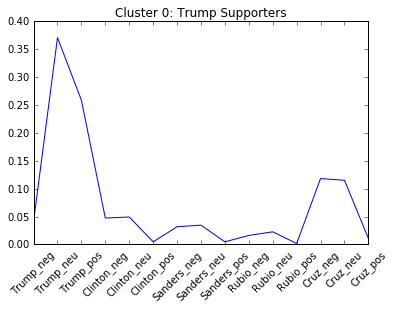

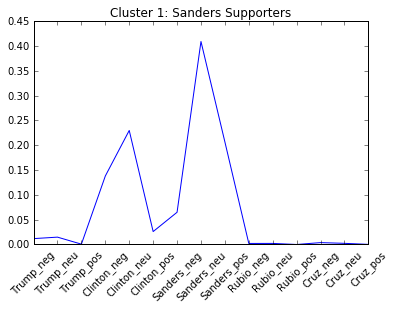

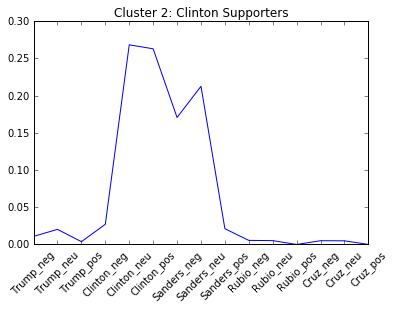

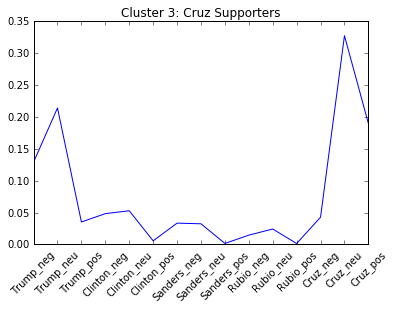

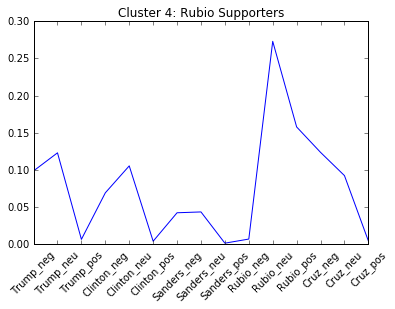

In [178]:
for i in range(len(code_book)):
    print i
    #y = pca.inverse_transform(centroids[K_ix_good][i])
    #y = pca.inverse_transform(centroids[centroids_ix][i])
    y = code_book[i]
    x = range(0, len(y))
    plt.figure(i)
    #plt.title('Cluster %d' % i )
    plt.title('Cluster {0}: {1} Supporters'.format(i, candidates[i]) )
    
    #ax = plt.subplot(3,4,i+1)
    #ax.set_xticks(my_features)
    plt.xticks(range(0, len(y)), features, size='medium', rotation=45)

    plt.plot(x, y)

In [224]:
# Graph accuracy and support for different minimum tweet thresholds.

scores = ['precision', 'recall', 'f-score', 'support']
results = {}
for candidate in candidates:
    results[candidate]={}
    for score in scores:
        results[candidate][score] = []
print results
for i in range(0,9):
    print i
    
    rest = summary_df.copy(deep=True)
    rest = rest[(rest[features] != 0).any(axis=1)]
    rest = rest[rest['frequency'] >= i]
    rest = rest[rest['frequency'] < 500]
    rest.reset_index()

    X = rest[features]
    
    code_book = []
    for key in candidates:
        code_book.append(Mean_ADC[key])
    code_book = np.vstack(code_book)
    X_labeled = vq(X.as_matrix(), code_book)

    tag_newdf = pd.DataFrame(columns=['user','supports','support_tag'])
    tag_newdf['user'] = rest['user']
    tag_newdf['supports'] = rest['supports']
    tag_newdf['supports_tag'] = X_labeled[0]

    tag_newdf['supports_tag'] = tag_newdf['supports_tag'].apply(lambda x : candidates[x])

    p_tag = tag_newdf[~(tag_newdf['supports'] == 'none')]
    p_tag[~(p_tag['supports'] == p_tag['supports_tag'])]
    
    y = p_tag['supports']
    y_pred = p_tag['supports_tag']

    #print confusion_matrix( y, y_pred )
    #print
    #print classification_report( y, y_pred )
    #print "Accuracy: ", metrics.accuracy_score( y, y_pred )
    
    if (i==1):
        support_denom = len(y)
  
    # Each of these functions returns a list of len(labels).
    temp_results = {}
    temp_results["precision"] = metrics.precision_score( y, y_pred, labels=candidates, average=None)
    print temp_results["precision"]
    temp_results["recall"] = metrics.recall_score( y, y_pred, labels=candidates, average=None)
    print temp_results["recall"]
    temp_results["f-score"] = metrics.f1_score( y, y_pred, labels=candidates, average=None)
    print temp_results["f-score"]
    temp_results["support"] = [float(len(y))/support_denom] * len(candidates)
    print temp_results["support"]

    for score in scores:
        i = 0
        for candidate in candidates:
            results[candidate][score].append(temp_results[score][i])
            i+=1
                                                 
    #score_results.append(results[candidate]["precision"].append(metrics.precision_score( y, y_pred, labels=candidates )))
    #score_results.append(results[candidate]["recall"].append(metrics.recall_score( y, y_pred, pos_label=candidates )))              
    #results[candidate]["f-score"].append(metrics.f1_score( y, y_pred, pos_label=candidates ))
    #results[candidate]["support"].append(float(len(y))/support_denom)

print 'done'
    

{'Sanders': {'f-score': [], 'recall': [], 'support': [], 'precision': []}, 'Cruz': {'f-score': [], 'recall': [], 'support': [], 'precision': []}, 'Clinton': {'f-score': [], 'recall': [], 'support': [], 'precision': []}, 'Trump': {'f-score': [], 'recall': [], 'support': [], 'precision': []}, 'Rubio': {'f-score': [], 'recall': [], 'support': [], 'precision': []}}
0
[ 0.88173142  0.84510187  0.58249497  0.73614776  0.54934211]
[ 0.7667457   0.80382267  0.80082988  0.70041841  0.7167382 ]
[ 0.82022828  0.82394558  0.67443215  0.71783877  0.62197393]
[1.0, 1.0, 1.0, 1.0, 1.0]
1
[ 0.88173142  0.84510187  0.58249497  0.73614776  0.54934211]
[ 0.7667457   0.80382267  0.80082988  0.70041841  0.7167382 ]
[ 0.82022828  0.82394558  0.67443215  0.71783877  0.62197393]
[1.0, 1.0, 1.0, 1.0, 1.0]
2
[ 0.91113841  0.86948392  0.6743215   0.80798274  0.55688623]
[ 0.82194311  0.85856721  0.81910397  0.73503435  0.76648352]
[ 0.86424548  0.86399108  0.73969466  0.76978417  0.64508671]
[0.7786341463414634,

In [225]:
print results

{'Sanders': {'f-score': [0.82394557823129255, 0.82394557823129255, 0.86399108138238578, 0.88681393759963567, 0.90192968543483998, 0.90930437334898739, 0.91688311688311697, 0.92152075340076745, 0.92593970971343498], 'recall': [0.80382267056012746, 0.80382267056012746, 0.85856720827178734, 0.88540245566166442, 0.9074468085106383, 0.91765402843601895, 0.92590163934426228, 0.93225123500352858, 0.93604213694507143], 'support': [1.0, 1.0, 0.7786341463414634, 0.6606829268292683, 0.5790243902439024, 0.5238048780487805, 0.4812682926829268, 0.44790243902439025, 0.4186341463414634], 'precision': [0.84510186994138992, 0.84510186994138992, 0.86948391922213908, 0.8882299270072993, 0.89647924330005258, 0.90110529377545079, 0.90803858520900327, 0.91103448275862065, 0.91605301914580262]}, 'Cruz': {'f-score': [0.71783876500857635, 0.71783876500857635, 0.76978417266187038, 0.78965922444183312, 0.81138318994043679, 0.82753623188405789, 0.84276729559748442, 0.84961767204757854, 0.8496849684968496], 'recall

Trump
[0 1 2 3 4 5 6 7 8]
Sanders
[0 1 2 3 4 5 6 7 8]
Clinton
[0 1 2 3 4 5 6 7 8]
Cruz
[0 1 2 3 4 5 6 7 8]
Rubio
[0 1 2 3 4 5 6 7 8]


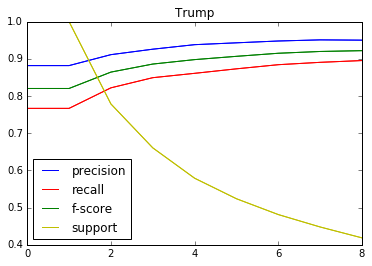

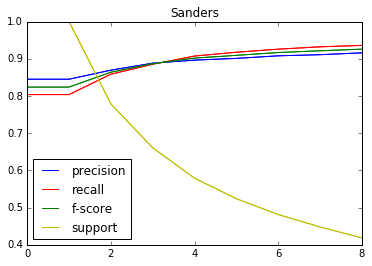

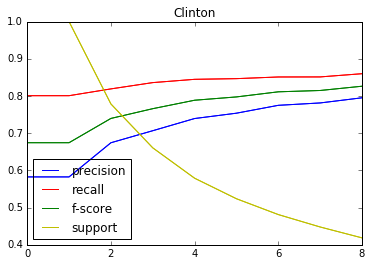

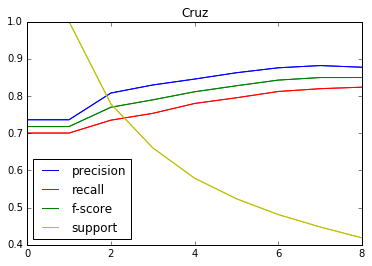

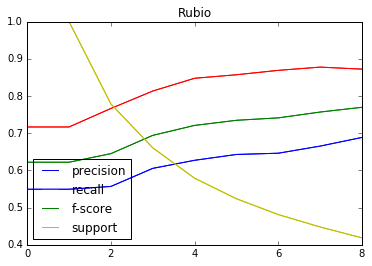

In [227]:
i = 0
for candidate in candidates:
    print candidate
    plt.figure(i)
    plt.title(candidate )
    #x = np.arange(0, len(relaxed_results[candidate]['precision'])/2, step)
    x = np.arange(0, len(results[candidate]['precision']))
    #x = [0, .5, 1.0, 1.5, 2.0]
    print x
    #np.arange(0, 5, 0.1)
    colors = ['-b', '-r', '-g', '-y']
    #for score in ['precision', 'recall', 'f-score', 'support']:
    for score, color in zip(['precision', 'recall', 'f-score', 'support'], colors):
        #print relaxed_results[candidate][score]    
        #y = centroids[centroids_ix][i]
        y = results[candidate][score] 
    
        #ax = plt.subplot(3,4,i+1)
        #ax.set_xticks(my_features)
        #plt.xticks(range(0, len(y)), cluster_features, size='small', rotation=45)
        
        plt.plot(x, y, color, label=score)
        plt.legend(loc='lower left')
        #pylab.plot(x, y1, '-b', label='sine')
        #pylab.plot(x, y2, '-r', label='cosine')
        #pylab.legend(loc='upper left')
        #pylab.ylim(-1.5, 2.0)
        #pylab.show()
        plt.locator_params(axis='x',nbins=4)
        plt.plot(x, y, color)
    i+=1